# Top Model

### Import Preliminaries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tqdm import *


# Prep Sample File Function
def prep_sample_submission (model_proba):
    model_proba['project_is_approved'] = 0
    for index, row in model_proba.iterrows():
        if model_proba.loc[index,0] > model_proba.loc[index,0]:
            model_proba.loc[index,'project_is_approved'] = model_proba.loc[index,0]
        else:
            model_proba.loc[index,'project_is_approved'] = model_proba.loc[index,1]
    return model_proba

pd.set_option('max_columns',1000)

### Import Data

In [2]:
# Import Data
test_data = pd.read_csv('Data/test.csv', low_memory=False)
train_data = pd.read_csv('Data/train.csv', low_memory=False)

train_df_classes = train_data['project_is_approved']

# Training Features
features = ['teacher_prefix', 'school_state', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories',
            'teacher_number_of_previously_posted_projects']

# Training and Testing Dataframes
train_df = train_data[features]
test_df = test_data[features]
train_df = train_df.fillna(value='No Essay')
test_df = test_df.fillna(value='No Essay')
test_ids = test_data.id

##### Encoding Values

In [3]:
for col in list(train_df.select_dtypes('object').columns):
    train_df[col] = train_df[col].astype('category')
    train_df[col] = train_df[col].cat.codes
    
for col in list(test_df.select_dtypes('object').columns):
    test_df[col] = test_df[col].astype('category')
    test_df[col] = test_df[col].cat.codes

##### Dataframe to Values

In [4]:
y = train_df_classes.values
X = train_df.values
X_test = test_df.values

## Logisical Model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Train the Logistic Model
model = LogisticRegression()
model.fit(X,y)

# Predict Sample Probabilities
logpred = pd.Series(model.predict(X_test), name='project_is_approved_result')
logpred_proba = pd.DataFrame(model.predict_proba(X_test))
logpred_sample_file = prep_sample_submission(logpred_proba)
logpred_sample_file = pd.concat([test_ids,logpred_sample_file.project_is_approved], axis=1)
logpred_sample_file.to_csv('Submissions/logistic_regression_submission.csv', index=False)

# Cross Validation Score
crossvalidation = KFold(10, random_state=1)
scores = cross_val_score(model, X, y, 
                scoring = 'accuracy',
                cv = crossvalidation, n_jobs =1)

print ('Folds: %i,accuracy: %.2f std: %.2f' 
% (len(scores),np.mean(np.abs(scores)),np.std(scores)))

logpred_sample_file.head()

Folds: 10,accuracy: 0.85 std: 0.00


,id,project_is_approved
0,p233245,0.837230
1,p096795,0.847115
2,p236235,0.808259
3,p233680,0.836270
4,p171879,0.854131


### Seperating Essay Data

In [6]:
# Taining Data
essay_features = ['project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary']

train_edf = train_data[essay_features]
test_edf = test_data[essay_features]

# Filter Essay Features
train_edf = train_data[essay_features]
test_edf = test_data[essay_features]

# Fill DataFrame
train_edf = train_edf.fillna(value='No Essay')
test_edf = test_edf.fillna(value='No Essay')

### Single Essay Model: Preprocessing

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Model Hyper Parameters
max_features = 10000
maxlen = 500
validation_split = 0.2

# Tokenization, Sequences, Word Index, and Word Embeddings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_edf.project_essay_1.values)
sequences = tokenizer.texts_to_sequences(train_edf.project_essay_1.values)
word_index = tokenizer.word_index
essay_one_data = pad_sequences(sequences, maxlen=maxlen)
essay_one_data = pd.DataFrame(essay_one_data)
essay_one_data = pd.concat([essay_one_data, train_df_classes], axis=1)
essay_one_data.head(10)

# Creating a list of Essay 1 features
essay_one_features = essay_one_data.columns[:-1]

# Converting DataFrame Values to Arrays
input_train = essay_one_data[essay_one_features].values
y_train = essay_one_data['project_is_approved'].values

essay_one_data.head(7)

Using TensorFlow backend.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,project_is_approved
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71,5,10,143,4,32,25,77,106,474,2,7,654,34,665,50,113,290,1,12,2445,14,186,2,71,17,285,188,962,187,1294,3174,25,14,1615,21,754,5,10,4,90,16,39,14,98,82,42,3,82,914,34,92,9,18,9,1649,10,143,113,17,31,505,8,1495,5,23,11,32,1,12,46,37,114,2,126,1,27,71,4,923,3,52,136,285,133,8,6,12,396,34,3,378,5,3,52,31,311,285,188,750,1,1338,46,37,11,1464,117,67,247,2,223,14,1223,1,235,11,7,582,295,1,27,60,129,61,37,22,7,6161,88,3,52,2,11,7,1027,1,189,673,11,138,138,33,1338,79,2227,597,1303,1,627,2,6,232,5,14,1839,1435,127,5,14,87,44,2,1085,13,74,114,1,156,3,790,22,43,256,25,417,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,234,12,16,6,815,690,12,19,6,83,170,5,9228,4,8,423,273,8

In [8]:
len(input_train)

182080

In [9]:
print(max_features)

10000


In [10]:
len(y_train)

182080

### Single Essay Model: Recurrent RNN in Keras

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

model = Sequential() 
model.add(Embedding(50000, 32))
model.add(SimpleRNN(32)) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          1600000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,602,113
Trainable params: 1,602,113
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 145664 samples, validate on 36416 samples
Epoch 1/10
145664/145664 [==============================] - 656s - loss: 0.4277 - acc: 0.8474 - val_loss: 0.4272 - val_acc: 0.8481
Epoch 2/10
145664/145664 [==============================] - 610s - loss: 0.4231 - acc: 0.8476 - val_loss: 0.4278 - val_acc: 0.8481
Epoch 3/10
145664/145664 [==============================] - 572s - loss: 0.4125 - acc: 0.8475 - val_loss: 0.4352 - val_acc: 0.8480
Epoch 4/10
145664/145664 [==============================] - 596s - loss: 0.3993 - acc: 0.8490 - val_loss: 0.4393 - val_acc: 0.8473
Epoch 5/10
145664/145664 [==============================] - 578s - loss: 0.3852 - acc: 0.8522 - val_loss: 0.4437 - val_acc: 0.8449
Epoch 6/10
145664/145664 [==============================] - 604s - loss: 0.3710 - acc: 0.8577 - val_loss: 0.4639 - val_acc: 0.8332
Epoch 7/10
145664/145664 [==============================] - 611s - loss: 0.3574 - acc: 0.8621 - val_loss: 0.4757 - val_acc: 0.8255
Epoch 8/10
145664/145664 [======

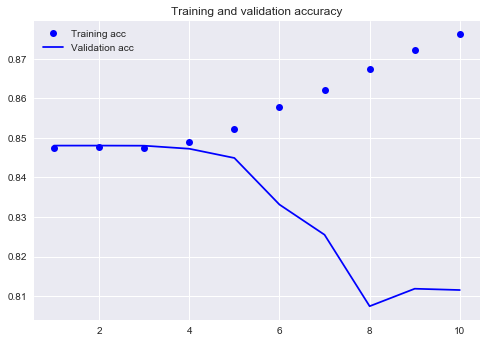

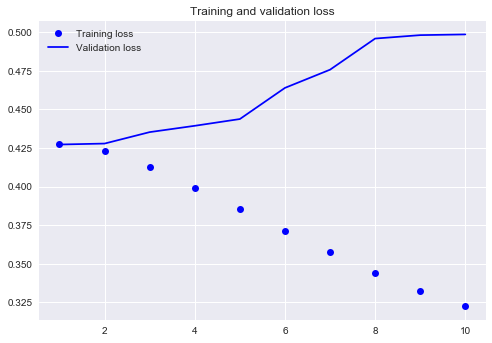

In [14]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
# Tokenization, Sequences, Word Index, and Word Embeddings
tokenizer = Tokenizer()
test_sequences = tokenizer.texts_to_sequences(train_edf.project_essay_1.values)
essay_one_test_data = pad_sequences(test_sequences, maxlen=maxlen)
essay_one_test_data = pd.DataFrame(essay_one_test_data)
essay_one_test_data = pd.concat([essay_one_test_data, train_df_classes], axis=1)

# Converting DataFrame Values to Arrays
input_test = essay_one_data[essay_one_features].values

AttributeError: 'Tokenizer' object has no attribute 'word_index'

In [ ]:
essay_one_test_data.head(10)